In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
from enum import Enum
import math

In [2]:
df = dict()
fdp = dict()
best_dist= dict()
best_fit_params = dict()

class Soal(Enum):
    FIFA = 1
    FRIDAY = 2
    ATHLETE = 3
    CRYPTO = 4

In [15]:
# Create models from data
# Terinspirasi dari https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
def best_fit_distribution(data, bins):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Cek distribusi yang mungkin
    DISTRIBUTIONS = [st.lognorm, 
                     st.expon, 
                     st.weibull_max, 
                     st.weibull_min, 
                     st.uniform, 
                     st.chi2, 
                     st.gamma, 
                     st.beta]

    # Set best-fit pertama
    best_dist = (st.norm,(0.0, 1.0))
    best_err = np.inf

    # Periksa masing-masing distribusi yang mungkin
    for dist in DISTRIBUTIONS:
        try:
            params = dist.fit(data)
            
            pdf = dist.pdf(x,
                           loc=params[-2],
                           scale=params[-1],
                           *params[:-2])
            
            err = np.sum(np.power(y - pdf, 2.0))
            if best_err > err and err > 0:
                best_dist = (dist, params)
                best_err = err
        except Exception:
            pass

    return best_dist

def make_pdf(dist, params, size=10000):
    dist_argument = params[:-2]
    dist_loc = params[-2]
    dist_scale = params[-1]

    if(dist_argument):
        start = dist.ppf(0.01, *dist_argument, loc=dist_loc, scale=dist_scale)
        end = dist.ppf(0.99, *dist_argument, loc=dist_loc, scale=dist_scale)
    else:
        start = dist.ppf(0.01, loc=dist_loc, scale=dist_scale)
        end = dist.ppf(0.99, loc=dist_loc, scale=dist_scale)

    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=dist_loc, scale=dist_scale, *dist_argument)

    return pd.Series(y, x)

def get_cdf(dist,x, params):
    return dist.cdf(x,*params)

# Soal 1 - Fifa

## Import Data

In [5]:
df[Soal.FIFA] = pd.read_csv('fifa.csv')

df[Soal.FIFA].head()

Name  Age Nationality
0           L. Messi   31   Argentina
1  Cristiano Ronaldo   33    Portugal
2          Neymar Jr   26      Brazil
3             De Gea   27       Spain
4       K. De Bruyne   27     Belgium

## Deskripsi Data

In [6]:
output = df[Soal.FIFA].describe()

output = output.append(pd.Series(df[Soal.FIFA].var(),name='var'))

output = output.append(pd.Series(df[Soal.FIFA]['Age'].mode().rename({0:'Age'}),
                                 name='mode'))

output = output.append(pd.Series(df[Soal.FIFA].skew(),name='skew'))

output = output.append(pd.Series(df[Soal.FIFA].kurtosis(),name='kurtosis'))

output

Age
count     18207.000000
mean         25.122206
std           4.669943
min          16.000000
25%          21.000000
50%          25.000000
75%          28.000000
max          45.000000
var          21.808365
mode         21.000000
skew          0.391764
kurtosis     -0.459514

## Visualisasi Data

### Histogram 

In [7]:
df[Soal.FIFA]['Age'].plot(kind='hist')

### Box Plot

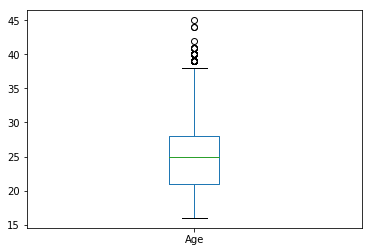

In [8]:
df[Soal.FIFA]['Age'].plot(kind='box')

### Kumulatif 

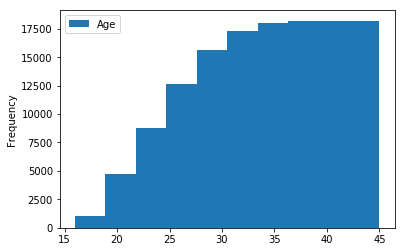

In [9]:
df[Soal.FIFA].plot(kind='hist',cumulative=True)

### Densitas 

In [10]:
df[Soal.FIFA].plot.density()

## Fungsi Densitas Peluang 

In [12]:
temp_data = df[Soal.FIFA]['Age']
param_bins = temp_data.max()-temp_data.min()

best_dist[Soal.FIFA], best_fit_params[Soal.FIFA] = best_fit_distribution(temp_data, param_bins)
fdp[Soal.FIFA] = make_pdf(best_dist[Soal.FIFA], best_fit_params[Soal.FIFA])
ax = fdp[Soal.FIFA].plot(lw=2, label='PDF', legend=True)
temp_data.plot(kind='hist', 
               bins=param_bins, 
               normed=True, 
               alpha=0.5, 
               label='Data', 
               legend=True, 
               ax=ax)

param_names = (best_dist[Soal.FIFA].shapes + ', loc, scale').split(', ') if best_dist[Soal.FIFA].shapes else ['loc', 'scale']
dist_param = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params[Soal.FIFA])])

ax.set_title('Distribusi Best-Fit\nDistribusi '+best_dist[Soal.FIFA].name+"\n"+ dist_param)
ax.set_xlabel('Umur')
ax.set_ylabel('Frekuensi')

plt.show()

Setelah dilakukan berbagai pengujian distribusi, disimpulkan distribusi yang paling mirip adalah distribusi beta. Dari perbandingan interpolasi grafik di atas, juga tampak bahwa distribusi beta dapat menghampiri distribusi yang ada dengan baik.

## Soal

### Jika terdapat 1000 pemain bola baru yang ditambahkan oleh Tsubasa, ekspektasi umur pemain bola yang:

In [13]:
n = 1000

### Berumur kurang dari 22 tahun ada:

In [16]:
print(math.floor(get_cdf(best_dist[Soal.FIFA],22,best_fit_params[Soal.FIFA])*n))

287


### Berumur lebih dari 40 tahun ada:

In [17]:
print(math.floor((1-get_cdf(best_dist[Soal.FIFA],40,best_fit_params[Soal.FIFA]))*n))

1


# Soal 3 Black Friday

## Import data

In [18]:
df[Soal.FRIDAY] = pd.read_csv('black_friday.csv',names=['Nilai'],header=None)
df[Soal.FRIDAY].head()

Nilai
0   8370
1  15200
2   1422
3   1057
4   7969

## Deskripsi Data

In [19]:
output = df[Soal.FRIDAY].describe()
output = output.append(pd.Series(df[Soal.FRIDAY].var(),name='var'))
output = output.append(pd.Series(df[Soal.FRIDAY]['Nilai'].mode().rename({0:'Nilai'}),name='mode'))
output = output.append(pd.Series(df[Soal.FRIDAY].skew(),name='skew'))
output = output.append(pd.Series(df[Soal.FRIDAY].kurtosis(),name='kurtosis'))

output

Nilai
count     5.375770e+05
mean      9.333860e+03
std       4.981022e+03
min       1.850000e+02
25%       5.866000e+03
50%       8.062000e+03
75%       1.207300e+04
max       2.396100e+04
var       2.481058e+07
mode      6.855000e+03
skew      6.242797e-01
kurtosis -3.431214e-01

## Visualisasi Data 

### Histogram

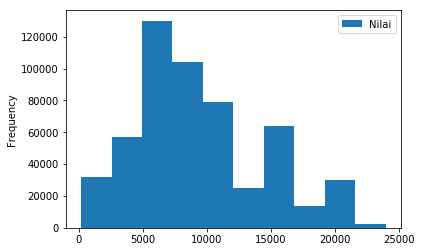

In [20]:
df[Soal.FRIDAY].plot(kind='hist')

### Box Plot

In [21]:
df[Soal.FRIDAY].plot(kind='box')

### Kumulatif

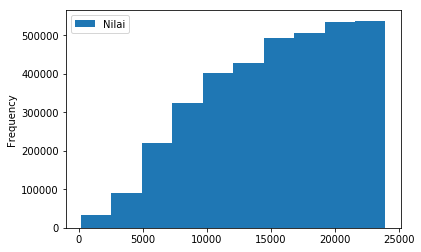

In [22]:
df[Soal.FRIDAY].plot(kind='hist',cumulative=True)

### Densitas

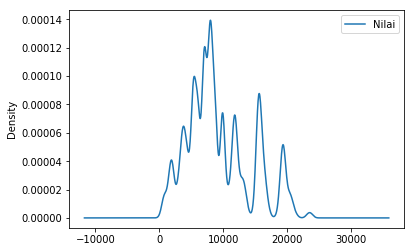

In [23]:
df[Soal.FRIDAY].plot.density()

## Fungsi Densitas Peluang

In [24]:
temp_data = df[Soal.FRIDAY]['Nilai']
param_bins = int((temp_data.max()-temp_data.min())/1000)

best_dist[Soal.FRIDAY], best_fit_params[Soal.FRIDAY] = best_fit_distribution(temp_data, param_bins)
fdp[Soal.FRIDAY] = make_pdf(best_dist[Soal.FRIDAY], best_fit_params[Soal.FRIDAY])
ax = fdp[Soal.FRIDAY].plot(lw=2, label='PDF', legend=True)
temp_data.plot(kind='hist', 
               bins=param_bins, 
               normed=True, 
               alpha=0.5, 
               label='Data', 
               legend=True, 
               ax=ax)

param_names = (best_dist[Soal.FRIDAY].shapes + ', loc, scale').split(', ') if best_dist[Soal.FRIDAY].shapes else ['loc', 'scale']
dist_param = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params[Soal.FRIDAY])])

ax.set_title('Distribusi Best-Fit\nDistribusi '+best_dist[Soal.FRIDAY].name+"\n"+ dist_param)
ax.set_xlabel('Harga')
ax.set_ylabel('Frekuensi')

plt.show()

Setelah dilakukan berbagai pengujian distribusi, disimpulkan distribusi yang paling mirip adalah distribusi lognormal. Dari perbandingan interpolasi grafik di atas, juga tampak bahwa distribusi lognormal dapat menghampiri distribusi yang ada dengan cukup baik.

## Soal

### Jika terdapat 250 orang pembeli baru yang mengikuti Black Friday,tentukan ekspektasi jumlah orang yang:

In [25]:
n = 250

#### Miskin (total pembelian kurang dari 1000 dolar)

In [26]:
print(math.floor(get_cdf(best_dist[Soal.FRIDAY],1000,best_fit_params[Soal.FRIDAY])*n))

2


#### Kaya (total pembelian lebih dari 10000 dolar)

In [27]:
print(math.floor((1-get_cdf(best_dist[Soal.FRIDAY],10000,best_fit_params[Soal.FRIDAY]))*n))

96


#### Crazy Rich (total pembelian lebih dari 20000 dolar)

In [28]:
print(math.floor((1-get_cdf(best_dist[Soal.FRIDAY],20000,best_fit_params[Soal.FRIDAY]))*n))

9


### Jika terdapat 1000 orang pembeli baru yang mengikuti Black Friday, tentukan ekspektasi jumlah orang yang sebenarnya pengeluarannya sama, seperti membeli:

In [29]:
n = 1000

#### Galaxy Fold (total pembelian di antara 1980–2000 dolar inklusif)

In [30]:
print(math.floor((get_cdf(best_dist[Soal.FRIDAY],2000,best_fit_params[Soal.FRIDAY])-get_cdf(best_dist[Soal.FRIDAY],1980,best_fit_params[Soal.FRIDAY]))*n))

0


#### MacBook Pro 2018 Touch Bar 256GB + iPhone XR + AirPods 2 (total pembelian di antara 2707–2897 dolar inklusif)

In [31]:
print(math.floor((get_cdf(best_dist[Soal.FRIDAY],2897,best_fit_params[Soal.FRIDAY])-get_cdf(best_dist[Soal.FRIDAY],2707,best_fit_params[Soal.FRIDAY]))*n))

7


# Soal 4 - Crypto

## Import Data

In [32]:
df[Soal.CRYPTO] = pd.read_csv('crypto.csv',names=['Nilai'],header=None)

df[Soal.CRYPTO].head()

Nilai
0  0.000015
1  0.000023
2  0.000033
3  0.000037
4  0.000037

## Deskripsi Data

In [33]:
df[Soal.CRYPTO].describe()

output = df[Soal.CRYPTO].describe()
output = output.append(pd.Series(df[Soal.CRYPTO].var(),name='var'))
output = output.append(pd.Series(df[Soal.CRYPTO]['Nilai'].mode().rename({0:'Nilai'}),name='mode'))
output = output.append(pd.Series(df[Soal.CRYPTO].skew(),name='skew'))
output = output.append(pd.Series(df[Soal.CRYPTO].kurtosis(),name='kurtosis'))

output

Nilai
count     6.322180e+05
mean      2.030181e+02
std       8.678734e+03
min       2.925000e-09
25%       8.070000e-04
50%       9.733500e-03
75%       1.198202e-01
max       2.383502e+06
var       7.532042e+07
mode      2.000000e-06
skew      1.182396e+02
kurtosis  2.229747e+04

## Visualisasi Data

### Histogram

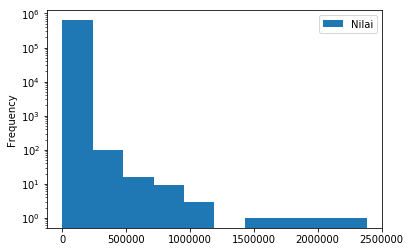

In [34]:
df[Soal.CRYPTO].plot(kind='hist',logy=True)

### Box Plot

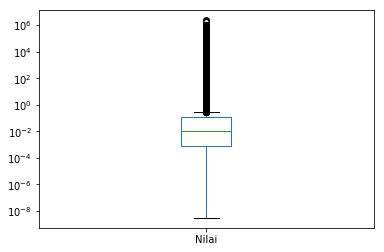

In [35]:
df[Soal.CRYPTO].plot(kind='box',logy=True)

### Kumulatif

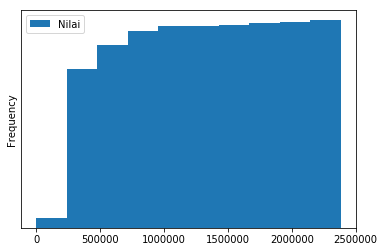

In [36]:
df[Soal.CRYPTO].plot(kind='hist',cumulative=True,logy=True)

### Densitas

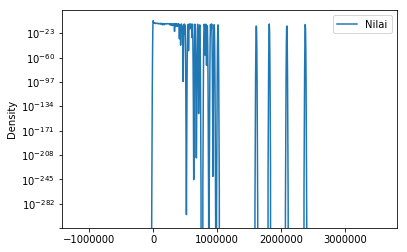

In [37]:
df[Soal.CRYPTO].plot(kind='density',logy=True)

## Fungsi Densitas Peluang

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


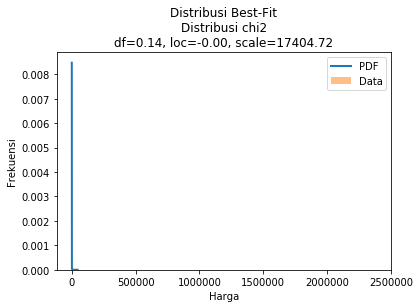

In [38]:
temp_data = df[Soal.CRYPTO]['Nilai']
param_bins = 100

best_dist[Soal.CRYPTO], best_fit_params[Soal.CRYPTO] = best_fit_distribution(temp_data, param_bins)
fdp[Soal.CRYPTO] = make_pdf(best_dist[Soal.CRYPTO], best_fit_params[Soal.CRYPTO])
ax = fdp[Soal.CRYPTO].plot(lw=2, label='PDF', legend=True)
temp_data.plot(kind='hist', 
               bins=param_bins, 
               normed=True, 
               alpha=0.5, 
               label='Data', 
               legend=True, 
               ax=ax)

param_names = (best_dist[Soal.CRYPTO].shapes + ', loc, scale').split(', ') if best_dist[Soal.CRYPTO].shapes else ['loc', 'scale']
dist_param = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params[Soal.CRYPTO])])

ax.set_title('Distribusi Best-Fit\nDistribusi '+best_dist[Soal.CRYPTO].name+"\n"+ dist_param)
ax.set_xlabel('Harga')
ax.set_ylabel('Frekuensi')

plt.show()

Setelah dilakukan berbagai pengujian distribusi, disimpulkan distribusi yang paling mirip adalah distribusi chi squared. Dari perbandingan interpolasi grafik di atas, juga tampak bahwa distribusi chi squared dapat menghampiri distribusi yang ada dengan baik.

### Apabila hari ini terdapat 1000 data harga *cryptocurrency* baru, tentukan ekspektasi jumlah *cryptocurrency* yang nilainya

In [39]:
n = 1000

#### Kurang dari 0.177013

In [40]:
print(math.floor(get_cdf(best_dist[Soal.CRYPTO],0.177013,best_fit_params[Soal.CRYPTO])*n))

449


#### Lebih dari 177.013

In [41]:
print(math.floor((1-get_cdf(best_dist[Soal.CRYPTO],177.013,best_fit_params[Soal.CRYPTO]))*n))

278


### Jika suatu hari terdapat sebuah *cryptocurrency* baru, tentukan peluang *cryptocurrency* tersebut bernilai

#### Lebih dari 0.013

In [42]:
print(1-get_cdf(best_dist[Soal.CRYPTO],0.013,best_fit_params[Soal.CRYPTO]))

0.6244701517282625


#### Kurang dari 17.7

In [43]:
print(1-get_cdf(best_dist[Soal.CRYPTO],17.7,best_fit_params[Soal.CRYPTO]))

0.3839548543449983


# Soal 5 - Athletes 

## Import Data 

In [44]:
df[Soal.ATHLETE] = pd.read_csv('athletes.csv')
df[Soal.ATHLETE].head()

Name  Medal
0                 A Dijiang      0
1                  A Lamusi      0
2  A. Aanantha Sambu Mayavo      0
3           A. Abdul Razzak      0
4                   A. Brun      0

## Deskripsi Data

In [45]:
output = df[Soal.ATHLETE].describe()
output = output.append(pd.Series(df[Soal.ATHLETE].var(),name='var'))
output = output.append(pd.Series(df[Soal.ATHLETE]['Medal'].mode().rename({0:'Medal'}),name='mode'))
output = output.append(pd.Series(df[Soal.ATHLETE].skew(),name='skew'))
output = output.append(pd.Series(df[Soal.ATHLETE].kurtosis(),name='kurtosis'))

output

Medal
count     134731.000000
mean           0.295277
std            0.724716
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max           28.000000
var            0.525213
mode           0.000000
skew           4.819999
kurtosis      51.562526

## Visualisasi Data 

### Histogram

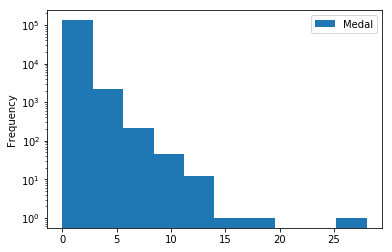

In [46]:
df[Soal.ATHLETE].plot(kind='hist',logy=True)

### Box Plot

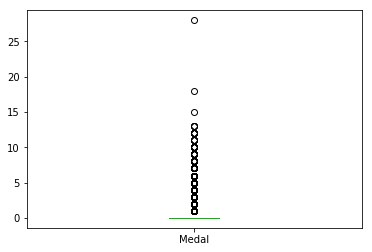

In [47]:
df[Soal.ATHLETE].plot(kind='box')

### Kumulatif

In [48]:
df[Soal.ATHLETE].plot(kind='hist',cumulative=True)

### Densitas

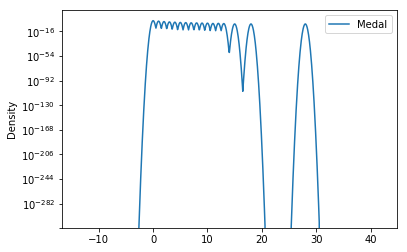

In [49]:
df[Soal.ATHLETE].plot(kind='density',logy=True)

## Fungsi Distribusi Peluang

In [51]:
temp_data = df[Soal.ATHLETE]['Medal']
param_bins = (temp_data.max()-temp_data.min())

best_dist[Soal.ATHLETE], best_fit_params[Soal.ATHLETE] = best_fit_distribution(temp_data, param_bins)
fdp[Soal.ATHLETE] = make_pdf(best_dist[Soal.ATHLETE], best_fit_params[Soal.ATHLETE])
ax = fdp[Soal.ATHLETE].plot(lw=2, label='PDF', legend=True)
temp_data.plot(kind='hist', 
               bins=param_bins, 
               normed=True, 
               alpha=0.5, 
               label='Data', 
               legend=True, 
               ax=ax)

param_names = (best_dist[Soal.ATHLETE].shapes + ', loc, scale').split(', ') if best_dist[Soal.ATHLETE].shapes else ['loc', 'scale']
dist_param = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params[Soal.ATHLETE])])

ax.set_title('Distribusi Best-Fit\nDistribusi '+best_dist[Soal.ATHLETE].name+"\n"+ dist_param)
ax.set_xlabel('Medal')
ax.set_ylabel('Frekuensi')

plt.show()

/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Setelah dilakukan berbagai pengujian distribusi, disimpulkan distribusi yang paling mirip adalah distribusi eksponensial. Dari perbandingan interpolasi grafik di atas, juga tampak bahwa distribusi eksponensial dapat menghampiri distribusi yang ada dengan baik.

### Peluang Y meraih

### Tepat 0 Medali

In [52]:
print(get_cdf(best_dist[Soal.ATHLETE],0.5,best_fit_params[Soal.ATHLETE]))

0.8160899630684494


### Lebih dari 10 medali

In [53]:
print(1-get_cdf(best_dist[Soal.ATHLETE],10.5,best_fit_params[Soal.ATHLETE]))

3.3306690738754696e-16


### Tepat 3 medali

In [54]:
print(get_cdf(best_dist[Soal.ATHLETE],3.5,best_fit_params[Soal.ATHLETE])-get_cdf(best_dist[Soal.ATHLETE],2.5,best_fit_params[Soal.ATHLETE]))

0.0002032749659723887


### 1 atau 5 medali

In [55]:
peluang1=get_cdf(best_dist[Soal.ATHLETE],1.5,best_fit_params[Soal.ATHLETE])-get_cdf(best_dist[Soal.ATHLETE],0.5,best_fit_params[Soal.ATHLETE])
peluang5=get_cdf(best_dist[Soal.ATHLETE],5.5,best_fit_params[Soal.ATHLETE])-get_cdf(best_dist[Soal.ATHLETE],4.5,best_fit_params[Soal.ATHLETE])
print(peluang1+peluang5)

0.17768989837792393


### Confidence Interval 95% tempat rata-rata

In [56]:
interval_range = best_dist[Soal.ATHLETE].interval(0.95,*best_fit_params[Soal.ATHLETE])

print(interval_range[0],"< X <",interval_range[1])

0.007475840027465502 < X < 1.089251988101056
